In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 加载IMDB数据集
# num_words=10000表示只保留最常见的10000个词，本身数据集有88582个词，如果未出现词，则用<UNK>表示
# 参数说明：
# - num_words: 保留的最常见词的数量
# - skip_top: 跳过最常见的若干词（通常是停用词）
# - maxlen: 序列最大长度
# - index_from: 词索引的起始值，默认为3
vocab_size=10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, index_from=3)

print(f"训练集样本数: {len(x_train)}, 测试集样本数: {len(x_test)}")
print(f"标签示例: {y_train[:10]}")  # 0表示负面评论，1表示正面评论

# 查看一个样本的词索引序列
print(f"一个样本的词索引序列: {x_train[0][:100]}...")

# 获取词索引映射，返回一个字典（词典），key是词，value是索引（token）
word_index = imdb.get_word_index()

word_index = {word: idx + 3 for word, idx in word_index.items()}  # 0,1,2,3空出来做别的事,这里的idx是从1开始的,所以加3
word_index.update({
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
})
# 创建索引到词的映射
reverse_word_index = {i: word for word, i in word_index.items()}

# 将一个样本的索引序列转换为文本
def decode_review(indices):
    return ' '.join([reverse_word_index.get(i, '?') for i in indices])

print("\n解码后的样本文本:")
print(decode_review(x_train[0]))


训练集样本数: 25000, 测试集样本数: 25000
标签示例: [1 0 0 1 0 0 1 0 1 0]
一个样本的词索引序列: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16]...

解码后的样本文本:
[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UN

In [2]:
reverse_word_index[4]

'the'

In [3]:
word_index['the']

4

In [4]:
# 将测试集划分为验证集和测试集
# 从原始测试集中取前10000个样本作为验证集
x_val = x_test[:10000]
y_val = y_test[:10000]

# 剩余的15000个样本作为测试集
x_test = x_test[10000:]
y_test = y_test[10000:]

print(f"验证集样本数: {len(x_val)}")
print(f"测试集样本数: {len(x_test)}")
print(f"验证集标签示例: {y_val[:10]}")
print(f"测试集标签示例: {y_test[:10]}")


验证集样本数: 10000
测试集样本数: 15000
验证集标签示例: [0 1 1 0 1 1 1 0 0 1]
测试集标签示例: [1 1 0 1 0 0 1 0 1 1]


In [5]:
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
raw_text

[['hello', 'world'],
 ['tokenize', 'text', 'datas', 'with', 'batch'],
 ['this', 'is', 'a', 'test']]

# 通过直方图来观察样本长度分布

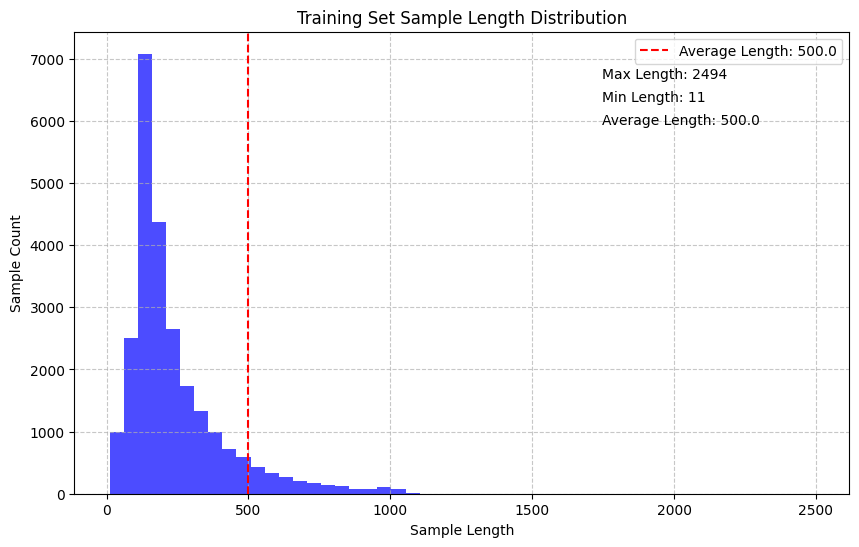

In [6]:
import matplotlib.pyplot as plt

# 计算每个样本的长度
train_lengths = [len(x) for x in x_train]

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sample Length')
plt.ylabel('Sample Count')
plt.title('Training Set Sample Length Distribution')
plt.grid(True, linestyle='--', alpha=0.7)

# 计算一些统计信息
max_length = max(train_lengths)
min_length = min(train_lengths)
avg_length = 500 #自定义了一个长度

# 在图上显示统计信息
plt.axvline(x=avg_length, color='r', linestyle='--', label=f'Average Length: {avg_length:.1f}')
plt.text(max_length*0.7, plt.ylim()[1]*0.9, f'Max Length: {max_length}')
plt.text(max_length*0.7, plt.ylim()[1]*0.85, f'Min Length: {min_length}')
plt.text(max_length*0.7, plt.ylim()[1]*0.8, f'Average Length: {avg_length:.1f}')
plt.legend()

plt.show()


# Tokenizer

In [ ]:
import numpy as np
import torch

class Tokenizer:
    def __init__(self, word_index, reverse_word_index):
        self.word_index = word_index
        self.reverse_word_index = reverse_word_index
        self.pad_token = 0  # <PAD>
        self.start_token = 1  # <START>
        self.unk_token = 2  # <UNK>
        self.end_token = 3  # <END>
    
    def encode(self, texts, maxlen=None, padding='post', truncating='post', add_start=False, add_end=False):
        """
        将文本序列转换为数字序列
        
        参数:
        - texts: 文本列表，每个元素是一个词列表
        - maxlen: 序列最大长度，如果为None则使用最长序列的长度
        - padding: 'pre'或'post'，表示在序列前或后填充
        - truncating: 'pre'或'post'，表示从序列前或后截断
        - add_start: 是否添加开始标记
        - add_end: 是否添加结束标记
        
        返回:
        - 编码后的序列
        """
        result = [] #编码后的序列，存储整个batch的序列
        
        # 计算需要的序列长度
        batch_max_len = max([len(seq) for seq in texts]) #batch内最长序列长度
        if add_start:
            batch_max_len += 1
        if add_end:
            batch_max_len += 1
            
        # 如果maxlen为None或者batch内最大长度小于maxlen，使用batch内最大长度
        if maxlen is None or batch_max_len < maxlen:
            maxlen = batch_max_len
        
        for text in texts:
            sequence = []
            
            # 添加开始标记
            if add_start:
                sequence.append(self.start_token)
            
            # 将词转换为索引
            for word in text:
                sequence.append(self.word_index.get(word, self.unk_token))  
            
            # 添加结束标记
            if add_end:
                sequence.append(self.end_token)
            
            # 截断序列
            if len(sequence) > maxlen:
                if truncating == 'pre':
                    sequence = sequence[-maxlen:]
                else:  # truncating == 'post'
                    sequence = sequence[:maxlen]
            
            # 填充序列
            pad_length = maxlen - len(sequence)
            if pad_length > 0:
                if padding == 'pre':
                    sequence = [self.pad_token] * pad_length + sequence
                else:  # padding == 'post'
                    sequence = sequence + [self.pad_token] * pad_length
            
            result.append(sequence)
        
        return np.array(result)
    
    def decode(self, sequences):
        """
        将数字序列转换回文本
        
        参数:
        - sequences: 数字序列列表
        
        返回:
        - 解码后的文本列表
        """
        result = []
        for sequence in sequences:
            words = []
            for idx in sequence:
                if idx == self.pad_token:
                    continue  # 跳过填充标记
                word = self.reverse_word_index.get(idx, '?')
                # if word not in ['[PAD]', '[BOS]', '[UNK]', '[EOS]']:
                words.append(word)
            result.append(' '.join(words))
        return result

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 创建Tokenizer实例
tokenizer = Tokenizer(word_index, reverse_word_index).to(device)

# 测试编码
encoded = tokenizer.encode(raw_text, maxlen=500, padding='post', add_start=True, add_end=True)
print("编码后的序列:")
print(encoded)

# 测试解码
decoded = tokenizer.decode(encoded)
print("\n解码后的文本:")
print(decoded)


编码后的序列:
[[    1  4825   182     3     0     0     0]
 [    1     2  3004     2    19 19233     3]
 [    1    14     9     6  2181     3     0]]

解码后的文本:
['[BOS] hello world [EOS]', '[BOS] [UNK] text [UNK] with batch [EOS]', '[BOS] this is a test [EOS]']


# Dataset和DataLoader

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class TextDataset(Dataset):
    """
    文本数据集类
    """
    def __init__(self, sequences, tokenizer, labels=None):
        """
        初始化文本数据集
        
        参数:
        - sequences: 编码后的序列
        - tokenizer: 分词器实例
        - labels: 标签（可选）
        """
        # 将编码序列解码为文本
        self.texts = tokenizer.decode(sequences)
        self.tokenizer = tokenizer
        self.labels = labels
    
    def __len__(self):
        """
        返回数据集大小
        """
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        获取指定索引的样本
        
        参数:
        - idx: 索引
        
        返回:
        - 样本（文本和标签，如果有的话）
        """
        if self.labels is not None:
            return self.texts[idx], self.labels[idx]
        return self.texts[idx]

def collate_fn(batch, tokenizer, maxlen=500):
    """
    自定义批处理函数，用于在加载数据时进行编码
    
    参数:
    - batch: 批次数据
    - tokenizer: 分词器实例
    - maxlen: 最大序列长度
    
    返回:
    - 编码后的序列和标签（如果有的话）
    """
    if isinstance(batch[0], tuple):
        # print(batch)
        # 如果批次包含标签
        text_list = [item[0].split() for item in batch]  #batch是128样本，每个样本类型是元组，第一个元素是文本，第二个元素是标签
        label_list = [item[1] for item in batch]
        # print(text_list)
        encoded = tokenizer.encode(text_list, maxlen=maxlen, padding='post', add_start=False, add_end=True)
        sequences = torch.tensor(encoded, dtype=torch.long)
        labels = torch.tensor(label_list, dtype=torch.float).view(-1, 1)  # 将标签reshape为二维 [batch_size, 1]
        return sequences, labels
    else:
        # 如果批次只有文本
        text_list = [item.split() for item in batch]
        encoded = tokenizer.encode(text_list, maxlen=maxlen, padding='post', add_start=False, add_end=True)
        sequences = torch.tensor(encoded, dtype=torch.long)
        return sequences

# 示例：创建数据集和数据加载器
# 假设我们有训练、验证和测试数据
# 创建对应的数据集
train_dataset = TextDataset(x_train, tokenizer, y_train)
val_dataset = TextDataset(x_val, tokenizer, y_val)
test_dataset = TextDataset(x_test, tokenizer, y_test)

# 创建数据加载器
batch_size = 64
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, tokenizer)
)

# 打印数据集和数据加载器信息
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

train_dataset[0:3]


训练集大小: 25000
验证集大小: 10000
测试集大小: 15000


(["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [9]:
# 示例：遍历训练数据加载器
print("\n训练数据加载器示例:")
for i, (batch_sequences, batch_labels) in enumerate(train_dataloader):
    print(f"批次 {i+1}:")
    print(f"序列形状: {batch_sequences.shape}")
    print(f"标签形状: {batch_labels.shape}")
    if i == 0:  # 只打印第一个批次
        break
batch_sequences


训练数据加载器示例:
批次 1:
序列形状: torch.Size([64, 500])
标签形状: torch.Size([64, 1])


tensor([[   1,    8, 3194,  ...,    0,    0,    0],
        [   1,   50,   71,  ...,    0,    0,    0],
        [   1,    6,  371,  ...,    0,    0,    0],
        ...,
        [   1,    2,   46,  ...,    0,    0,    0],
        [   1,   13,  115,  ...,    0,    0,    0],
        [   1,    7,  265,  ...,    0,    0,    0]])

# 搭建模型

In [10]:
from torch import nn
m = nn.AdaptiveAvgPool1d(1)  #输出形状为[batch_size, embedding_dim, 1],把最后一个维度size变成1
input = torch.randn(1, 64, 8) 
output = m(input)
output.shape

torch.Size([1, 64, 1])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=16, hidden_dim=128, output_dim=1):
        super().__init__()
        
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 自适应池化层 - 将不同长度的序列转换为固定长度的表示
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # 全连接层
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Dropout层，防止过拟合
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # x形状: [batch_size, seq_len]
        
        # 通过嵌入层
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # 调整维度以适应池化层
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        # 应用自适应池化
        pooled = self.adaptive_pool(embedded)  # [batch_size, embedding_dim, 1]
        pooled = pooled.squeeze(2)  # [batch_size, embedding_dim]
        
        # 通过全连接层
        hidden = F.relu(self.fc1(pooled))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)
        
        return output

# 初始化模型
model = SentimentClassifier(vocab_size).to(device)
print(f"模型结构:\n{model}")

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss() #WithLogitsLoss代表的含义是：把输出结果通过sigmoid函数，然后计算损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 打印模型参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型参数数量: {count_parameters(model):,}")


模型结构:
SentimentClassifier(
  (embedding): Embedding(10000, 16)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
模型参数数量: 162,305


In [12]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
# 验证模型的前向计算
# 从训练数据中获取一个批次的样本
sample_batch, sample_labels = next(iter(train_dataloader))
print(f"输入形状: {sample_batch.shape}")

# 将样本移动到设备上
sample_batch = sample_batch.to(device)

# 进行前向计算
with torch.no_grad():
    outputs = model(sample_batch)
    print(f"输出形状: {outputs.shape}")
    


使用设备: cpu
输入形状: torch.Size([64, 500])
输出形状: torch.Size([64, 1])


# 训练，画图，评估

In [13]:
from deeplearning_model_new import train_two_classification_model, evaluate_two_classification_model,plot_learning_curves,EarlyStopping,ModelSaver

model = SentimentClassifier(vocab_size).to(device)
print(f"模型结构:\n{model}")

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss() #WithLogitsLoss代表的含义是：把输出结果通过sigmoid函数，然后计算损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 将模型移动到设备上
model = model.to(device)


# 训练参数
num_epochs = 20
eval_step = 100

# 训练模型
# 创建早停和模型保存器
early_stopping = EarlyStopping(patience=5, delta=0.001)
model_saver = ModelSaver(save_dir='weights')

model, record_dict = train_two_classification_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_step=eval_step,
    early_stopping=early_stopping,
    model_saver=model_saver
)




模型结构:
SentimentClassifier(
  (embedding): Embedding(10000, 16)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
训练开始，共7820步


  0%|          | 0/7820 [00:00<?, ?it/s]

早停触发!
87.7000
早停: 在3600 步


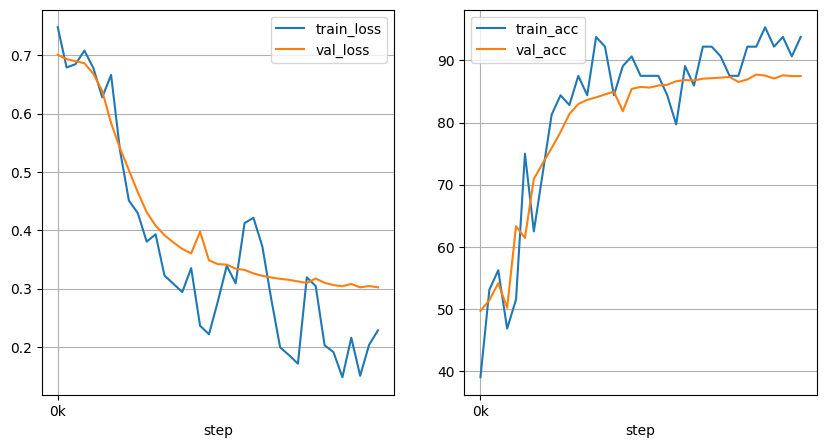

In [14]:
# 绘制学习曲线
plot_learning_curves(record_dict,sample_step=100)


In [15]:


# 在测试集上评估最终模型
test_acc, test_loss = evaluate_two_classification_model(model, test_dataloader, device, criterion)
print(f"测试集准确率: {test_acc:.2f}%, 测试集损失: {test_loss:.4f}")

测试集准确率: 88.06%, 测试集损失: 0.2917
